In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 1000

In [9]:
listings = pd.read_csv('data/listings.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)

#### correção dos dados

In [10]:
listings['price'] = pd.to_numeric(listings['price'].str.replace('$','').str.replace(',',''), errors='coerce')
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'], errors='coerce').sort_values()
listings['host_since'] = pd.to_datetime(listings['host_since'], errors='coerce').sort_values()
listings['calendar_last_scraped'] = pd.to_datetime(listings['calendar_last_scraped'], errors='coerce').sort_values()
listings['first_review'] = pd.to_datetime(listings['first_review'], errors='coerce').sort_values()
listings['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce').sort_values()
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.replace('%',''), errors='coerce')
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str.replace('%',''), errors='coerce')

### avaliação dos tipos de dados

In [11]:
print(listings.dtypes)

id                                                       int64
listing_url                                             object
scrape_id                                                int64
last_scraped                                    datetime64[ns]
name                                                    object
description                                             object
neighborhood_overview                                   object
picture_url                                             object
host_id                                                  int64
host_url                                                object
host_name                                               object
host_since                                      datetime64[ns]
host_location                                           object
host_about                                              object
host_response_time                                      object
host_response_rate                                     

In [12]:
listings.select_dtypes(include=['datetime64[ns]']).describe()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
count,26615,26591,26615,16657,16657
unique,4,3392,4,2610,1469
top,2021-02-24 00:00:00,2020-10-07 00:00:00,2021-02-24 00:00:00,2020-02-26 00:00:00,2020-02-26 00:00:00
freq,13192,298,13192,262,681
first,2021-02-22 00:00:00,2008-10-13 00:00:00,2021-02-22 00:00:00,2010-06-07 00:00:00,2012-02-21 00:00:00
last,2021-02-25 00:00:00,2021-02-19 00:00:00,2021-02-25 00:00:00,2021-02-23 00:00:00,2021-02-25 00:00:00


### avaliação dos missings

In [13]:
round((len(listings) - listings.loc[:, listings.isna().mean() > 0].count())/len(listings),3).sort_values(ascending=False)

bathrooms                       1.000
license                         1.000
calendar_updated                1.000
neighbourhood_group_cleansed    1.000
host_about                      0.515
neighborhood_overview           0.462
neighbourhood                   0.462
host_neighbourhood              0.423
review_scores_value             0.395
review_scores_location          0.395
review_scores_communication     0.395
review_scores_checkin           0.395
review_scores_cleanliness       0.395
review_scores_accuracy          0.395
review_scores_rating            0.394
reviews_per_month               0.374
last_review                     0.374
first_review                    0.374
host_acceptance_rate            0.358
host_response_time              0.301
host_response_rate              0.301
bedrooms                        0.066
description                     0.055
beds                            0.009
host_location                   0.004
minimum_maximum_nights          0.003
maximum_maxi

### análise descritiva dos dados

In [14]:
listings.select_dtypes(include=['category', 'object']).describe()

,listing_url,name,description,neighborhood_overview,picture_url,host_url,host_name,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,has_availability,instant_bookable
count,26615,26586,25160,14314,26615,26615,26591,26508,12895,18599,26591,26591,26591,15344,26615,26591,26591,14314,26615,26615,26615,26543,26615,26615,26615
unique,26615,25807,24458,13121,26129,17324,5145,963,6975,4,2,17220,17220,156,358,2,2,271,151,87,4,52,23932,2,2
top,https://www.airbnb.com/rooms/4157165,Apartamento em Copacabana,Super comfortable apartment in Barra da Tijuca...,"Copacabana, a name synonym of paradise. The wa...",https://a0.muscache.com/pictures/ac50dd2b-7158...,https://www.airbnb.com/users/show/371026651,Daniel,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Meu nome é Daniel, eu sou francês e moro no Br...",within an hour,f,https://a0.muscache.com/im/pictures/user/64b61...,https://a0.muscache.com/im/pictures/user/64b61...,Copacabana,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Copacabana,Entire apartment,Entire home/apt,1 bath,"[""Long term stays allowed""]",t,f
freq,1,34,17,18,11,295,312,13176,198,8792,22038,295,295,5426,3968,26502,16766,5530,7712,15354,19285,10648,302,25830,17466


In [15]:
listings.select_dtypes(include=np.number).describe()

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.661500e+04,2.661500e+04,2.661500e+04,18599.000000,17074.000000,26591.000000,26591.000000,0.0,26615.000000,26615.000000,26615.000000,0.0,24869.000000,26363.000000,26615.000000,26615.000000,2.661500e+04,26531.000000,26531.000000,2.653100e+04,2.653100e+04,26531.000000,2.653100e+04,0.0,26615.000000,26615.000000,26615.000000,26615.000000,26615.000000,26615.000000,26615.000000,16118.000000,16104.000000,16107.000000,16106.000000,16110.000000,16106.000000,16108.000000,0.0,26615.000000,26615.000000,26615.000000,26615.000000,16657.000000
mean,2.526448e+07,2.021022e+13,1.006657e+08,83.481800,75.680508,9.367568,9.367568,NaN,-22.965837,-43.248533,4.161112,NaN,1.707909,2.548230,742.589254,4.725268,3.819109e+04,4.660510,5.032038,3.842962e+04,3.843929e+04,4.788828,3.843440e+04,NaN,19.245200,41.221379,64.233440,219.438174,12.146308,2.341725,0.296487,94.571349,9.636612,9.392376,9.799888,9.758535,9.759717,9.296374,NaN,9.665414,8.259177,1.295022,0.087620,0.629190
std,1.573416e+07,0.000000e+00,1.090670e+08,30.859979,33.309700,93.121768,93.121768,NaN,0.034971,0.096296,2.494174,NaN,1.054267,2.127716,5368.868834,19.102522,6.129662e+06,18.908336,19.572665,6.139357e+06,6.139357e+06,19.222567,6.139357e+06,NaN,12.455029,23.794758,34.644936,141.525405,29.722813,5.707102,0.882080,9.740887,0.940490,1.138224,0.767390,0.829072,0.749132,1.053340,NaN,35.942124,31.611146,5.300625,0.622397,0.876064
min,1.787800e+04,2.021022e+13,3.607000e+03,0.000000,0.000000,0.000000,0.000000,NaN,-23.072920,-43.704790,0.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.220219e+07,2.021022e+13,1.431500e+07,86.000000,61.000000,1.000000,1.000000,NaN,-22.984570,-43.304090,2.000000,NaN,1.000000,1.000000,157.000000,1.000000,3.000000e+01,1.000000,2.000000,9.000000e+01,9.000000e+01,1.600000,9.000000e+01,NaN,3.000000,23.000000,43.000000,88.000000,0.000000,0.000000,0.000000,93.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.090000
50%,2.374090e+07,2.021022e+13,6.026326e+07,100.000000,94.000000,1.000000,1.000000,NaN,-22.971700,-43.196210,4.000000,NaN,1.000000,2.000000,280.000000,2.000000,1.000000e+03,2.000000,3.000000,1.125000e+03,1.125000e+03,2.200000,1.125000e+03,NaN,27.000000,56.000000,86.000000,254.000000,2.000000,0.000000,0.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.270000
75%,4.089613e+07,2.021022e+13,1.546962e+08,100.000000,100.000000,4.000000,4.000000,NaN,-22.951575,-43.186300,5.000000,NaN,2.000000,3.000000,550.000000,4.000000,1.125000e+03,4.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,NaN,30.000000,59.000000,89.000000,363.000000,9.000000,2.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,2.000000,1.000000,0.000000,0.850000
max,4.827600e+07,2.021022e+13,3.892463e+08,10

### separação dos tipos de dados

In [17]:
vars_cat = listings[['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','bathrooms_text','has_availability','instant_bookable']]
vars_num = listings[['host_listings_count','host_total_listings_count','host_response_rate','host_acceptance_rate','latitude','longitude','accommodates','beds','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','reviews_per_month','price']]
vars_time = listings[['host_since','first_review','last_review']]
#Features removidas dado o vazamento de dados
#'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'
#property_type

### correção dos valores categóricos

In [18]:
vars_cat.replace(' ', '_', regex=True, inplace=True)
vars_cat.describe()

c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,bathrooms_text,has_availability,instant_bookable
count,18599,26591,26591,26591,26615,26543,26615,26615
unique,4,2,2,2,151,52,2,2
top,within_an_hour,f,t,t,Copacabana,1_bath,t,f
freq,8792,22038,26502,16766,7712,10648,25830,17466


### criação de novas features levando em consideração os valores de datetime

In [19]:
vars_time.loc[:,'host_since_delta_days'] = (pd.to_datetime('2021-02-25') - pd.to_datetime(vars_time.host_since, errors='coerce')).dt.days
vars_time.loc[:,'first_review_delta_days'] = (pd.to_datetime('2021-02-25') - pd.to_datetime(vars_time.first_review, errors='coerce')).dt.days
vars_time.loc[:,'last_review_delta_days'] = (pd.to_datetime('2021-02-25') - pd.to_datetime(vars_time.last_review, errors='coerce')).dt.days
vars_time.loc[:,'time_to_first_review_days'] = (pd.to_datetime(vars_time.first_review, errors='coerce') - pd.to_datetime(vars_time.host_since, errors='coerce')).dt.days
vars_time.loc[:,'time_to_last_review_days'] = (pd.to_datetime(vars_time.last_review, errors='coerce') - pd.to_datetime(vars_time.host_since, errors='coerce')).dt.days
vars_time.loc[:,'time_bt_first_last_review_days'] = (pd.to_datetime(vars_time.last_review, errors='coerce') - pd.to_datetime(vars_time.first_review, errors='coerce')).dt.days

vars_time.drop(['host_since','first_review','last_review'], axis=1, inplace=True)
vars_time.describe()

c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,host_since_delta_days,first_review_delta_days,last_review_delta_days,time_to_first_review_days,time_to_last_review_days,time_bt_first_last_review_days
count,26591.000000,16657.000000,16657.000000,16642.000000,16642.000000,16657.000000
mean,1837.626603,1072.277901,365.877049,846.746966,1553.271302,706.400852
std,879.534196,780.987193,474.566576,805.753307,904.192140,757.000140
min,6.000000,2.000000,0.000000,-1400.000000,-811.000000,0.000000
25%,1226.500000,421.000000,32.000000,143.000000,817.250000,36.000000
50%,1828.000000,830.000000,297.000000,614.000000,1550.000000,434.000000
75%,2508.000000,1653.000000,421.000000,1360.000000,2210.000000,1174.000000
max,4518.000000,3916.000000,3292.000000,3782.000000,4329.000000,3861.000000


### correção de anomalias dos datetimes

In [20]:
vars_time.loc[:,'time_to_first_review_days'].loc[vars_time.loc[:,'time_to_first_review_days'] < 0] = 0
vars_time.loc[:,'time_to_last_review_days'].loc[vars_time.loc[:,'time_to_last_review_days'] < 0] = 0
vars_time.describe()

c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,host_since_delta_days,first_review_delta_days,last_review_delta_days,time_to_first_review_days,time_to_last_review_days,time_bt_first_last_review_days
count,26591.000000,16657.000000,16657.000000,16642.000000,16642.000000,16657.000000
mean,1837.626603,1072.277901,365.877049,848.508412,1553.437988,706.400852
std,879.534196,780.987193,474.566576,803.022371,903.858657,757.000140
min,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1226.500000,421.000000,32.000000,143.000000,817.250000,36.000000
50%,1828.000000,830.000000,297.000000,614.000000,1550.000000,434.000000
75%,2508.000000,1653.000000,421.000000,1360.000000,2210.000000,1174.000000
max,4518.000000,3916.000000,3292.000000,3782.000000,4329.000000,3861.000000


In [21]:
vars_num = pd.concat([vars_num.reset_index(drop=True), vars_time], axis=1)
vars_num.head()

,host_listings_count,host_total_listings_count,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,price,host_since_delta_days,first_review_delta_days,last_review_delta_days,time_to_first_review_days,time_to_last_review_days,time_bt_first_last_review_days
0,2.0,2.0,100.0,100.0,-22.96592,-43.17896,5,2.0,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,0,8,38,304,260,12,2,94.0,9.0,9.0,10.0,10.0,10.0,9.0,1,2.01,221.0,4066.0,3878.0,17.0,188.0,4049.0,3861.0
1,0.0,0.0,100.0,NaN,-22.98570,-43.20193,2,1.0,3,90,3.0,3.0,90.0,90.0,3.0,90.0,0,0,0,10,85,0,0,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0.67,307.0,3989.0,3805.0,1107.0,184.0,2882.0,2698.0
2,11.0,11.0,97.0,78.0,-22.97712,-43.19045,2,2.0,7,60,7.0,7.0,60.0,60.0,7.0,60.0,0,23,53,328,238,0,0,94.0,9.0,9.0,9.0,10.0,10.0,9.0,11,1.82,160.0,3067.0,3916.0,376.0,0.0,2691.0,3540.0
3,1.0,1.0,NaN,100.0,-22.98816,-43.19359,2,1.0,2,89,2.0,2.0,89.0,89.0,2.0,89.0,0,0,0,207,181,2,0,94.0,10.0,9.0,10.0,10.0,10.0,9.0,1,2.02,273.0,3896.0,2683.0,347.0,1213.0,3549.0,2336.0
4,1.0,1.0,100.0,94.0,-22.98127,-43.19046,2,1.0,3,15,3.0,3.0,3.0,15.0,3.0,15.0,4,4,22,101,353,25,4,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.79,135.0,3896.0,3798.0,15.0,98.0,3881.0,3783.0


### tratamento da variável alvo

In [22]:
cls= {
    'Entire home/apt':0,
    'Private room':1,
    'Shared room':2,
    'Hotel room':3,
}
y = listings['room_type'].apply(lambda x: cls[x])

c:\users\jam\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


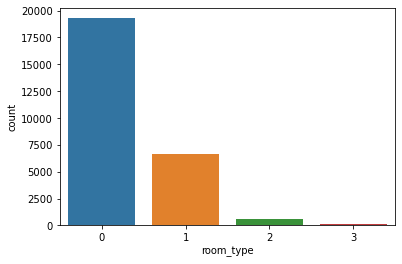

In [23]:
sns.countplot(y)

In [24]:
y.value_counts()/len(y)

0    0.724591
1    0.248694
2    0.022995
3    0.003720
Name: room_type, dtype: float64

###### apesar das categorias 2 e 3 terem percentuais bem baixos, resolvi considera-las por não ter o contexto completo do negócio e não saber sua real necessidade de entrar no modelo

### avaliação de correlações entre variáveis explicativas

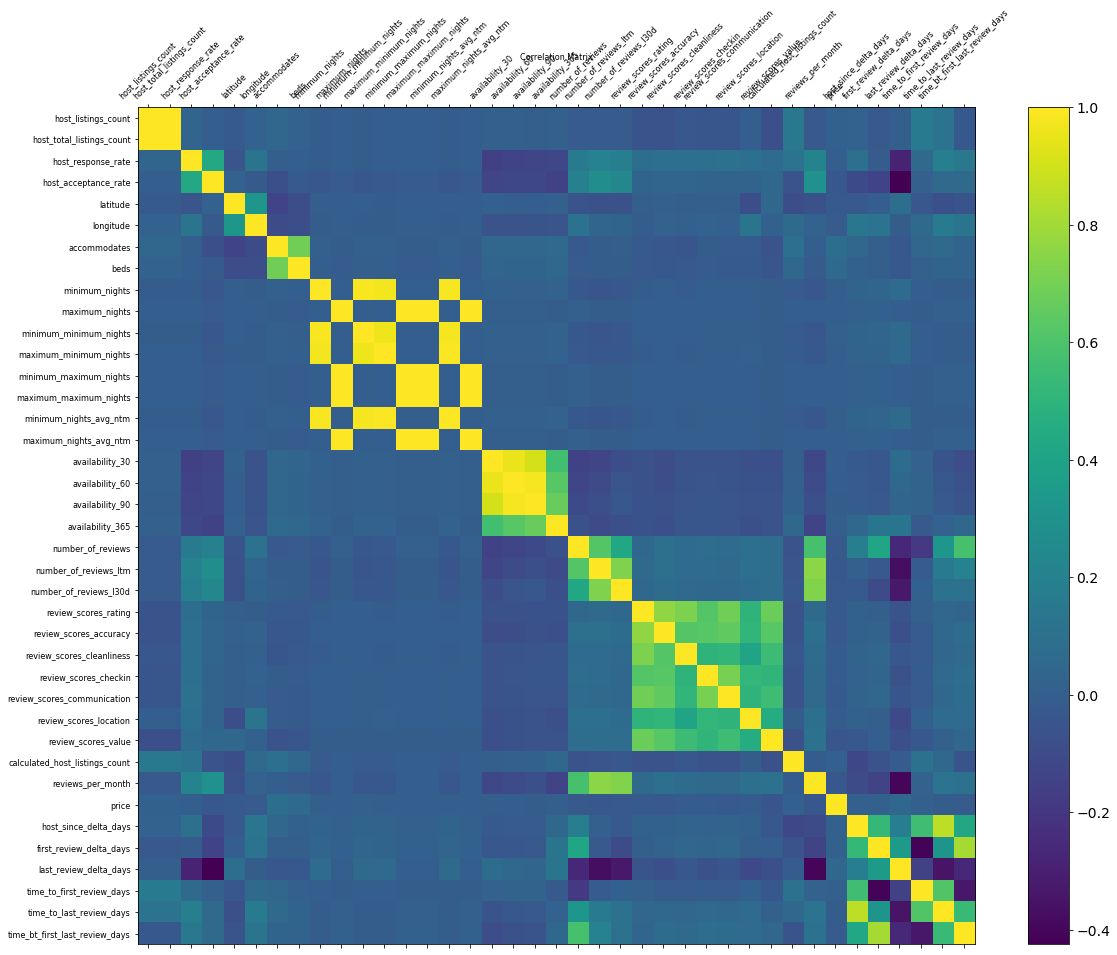

In [25]:
import matplotlib.pyplot as plt

vars = pd.concat([vars_num.reset_index(drop=True), vars_cat], axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(vars.corr(), fignum=f.number)
plt.xticks(range(vars.select_dtypes(['number']).shape[1]), vars.select_dtypes(['number']).columns, fontsize=8, rotation=45)
plt.yticks(range(vars.select_dtypes(['number']).shape[1]), vars.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=8);

### remoção de variáveis com alta correlação

In [26]:
drop_corr = list(correlation(vars,0.7))
vars_num = vars_num.drop(drop_corr, axis=1, errors='ignore')
vars_cat = vars_cat.drop(drop_corr, axis=1, errors='ignore')

### transformação de colunas numéricas e categóricas

In [27]:
num_feat_name = num_feat_name = vars_num.columns
imp_num = clipNumOutlier(vars_num, 0.01, 0.99)
imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
X_num = MinMaxScaler().fit_transform(imp_num.fit_transform(vars_num))
X_num.shape

(26615, 24)

In [28]:
imp_cat = imputCat(vars_cat,sub_value='Unknown')
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = enc.fit_transform(imp_cat)
cat_feat_name = enc.get_feature_names(list(imp_cat.columns))
X_cat.shape

(26615, 222)

In [29]:
from unidecode import unidecode

X_cat = np.matrix(X_cat)
X_num = np.matrix(X_num)
X = np.hstack((X_cat,X_num))
feat_name = np.concatenate((cat_feat_name,num_feat_name))
feat_name = [unidecode(x) for x in feat_name]

### divisão entre treino e teste

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [31]:
#import xgboost as xgb

#train = xgb.DMatrix(X_train, label=y_train)
#test = xgb.DMatrix(X_test, label=y_test)

### padronização do grid para realizar o cross-validation e obter os melhores parâmetros

In [32]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [34]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, num_class=4, objective='multi:softmax',silent=True, nthread=1)

folds = 4
param_comb = 4

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc_ovr', n_jobs=4, cv=skf.split(X_train,y_train), 
                                   verbose=3, random_state=1001 )

start_time = timer(None)
model.fit(X_train,y_train)
timer(start_time)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed: 69.8min finished



 Time taken: 1 hours 17 minutes and 38.2 seconds.


In [36]:
print('\n Best estimator:')
print(model.best_estimator_)
print('\n Best hyperparameters:')
print(model.best_params_)
results = pd.DataFrame(model.cv_results_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.6, verbosity=1)

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 1.5, 'colsample_bytree': 0.8}


### predição utilizando os parâmetros otimizados

In [37]:
pred = model.predict(X_test)

In [44]:
model_otm = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.6, verbosity=1)

In [45]:
pred = model_otm.fit(X_train,y_train).predict(X_test)

In [46]:
model_otm.save_model('model_v1.json')

### avaliação do modelo

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4821
           1       0.88      0.82      0.85      1655
           2       0.70      0.31      0.43       153
           3       1.00      0.20      0.33        25

    accuracy                           0.93      6654
   macro avg       0.88      0.58      0.64      6654
weighted avg       0.92      0.93      0.92      6654



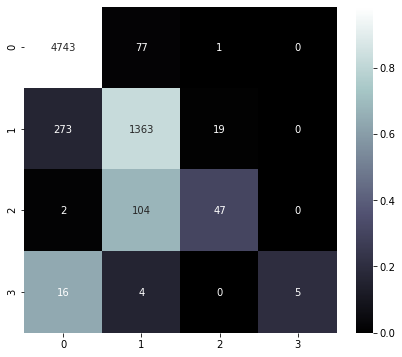

In [48]:
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, ['0', '1', '2','3'])

In [79]:
from sklearn.metrics import roc_auc_score

y_prob = model_otm.predict_proba(X_train)
macro_roc_auc_ovo = roc_auc_score(y_train, y_prob, multi_class="ovo",
                              average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_train, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_train, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_train, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
#X_train, X_test, y_train, y_test

One-vs-One ROC AUC scores:
0.341785 (macro),
0.234725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.277079 (macro),
0.028754 (weighted by prevalence)


In [81]:
y_prob = model_otm.predict_proba(X_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                              average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.340548 (macro),
0.232961 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.275420 (macro),
0.034417 (weighted by prevalence)


### avaliação das features mais importante

In [49]:
create_feature_map(feat_name)

In [51]:
import operator
sc = model_otm.get_booster().get_score(importance_type='gain', fmap=r'xgb.fmap')
sc = sorted(sc.items(), key=operator.itemgetter(1))
sc

[('neighbourhood_cleansed_Praca_da_Bandeira', 0.9691051137272727),
 ('bathrooms_text_Unknown', 1.3597910399000002),
 ('neighbourhood_cleansed_Estacio', 1.5471353826060605),
 ('bathrooms_text_5_baths', 1.76139164),
 ('host_response_time_a_few_days_or_more', 2.25559926),
 ('neighbourhood_cleansed_Leblon', 2.3807275226470592),
 ('review_scores_accuracy', 2.547457288235294),
 ('neighbourhood_cleansed_Rio_Comprido', 2.62929726),
 ('review_scores_communication', 2.6340012862894735),
 ('bathrooms_text_2.5_baths', 2.809849647692307),
 ('neighbourhood_cleansed_Taquara', 3.07699537),
 ('neighbourhood_cleansed_Santa_Cruz', 3.11305904),
 ('neighbourhood_cleansed_Botafogo', 3.206528322857143),
 ('review_scores_cleanliness', 3.2082747768292683),
 ('neighbourhood_cleansed_Freguesia_(Jacarepagua)', 3.21199501),
 ('review_scores_location', 3.288849554516129),
 ('time_to_first_review_days', 3.4243870092857134),
 ('neighbourhood_cleansed_Vargem_Grande', 3.56206226),
 ('host_is_superhost_t', 3.56858218),


In [52]:
importance = model_otm.get_booster().get_fscore(fmap=r'xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
importance

[('bathrooms_text_7_shared_baths', 1),
 ('neighbourhood_cleansed_Rio_Comprido', 1),
 ('neighbourhood_cleansed_Cosme_Velho', 1),
 ('neighbourhood_cleansed_Catete', 1),
 ('neighbourhood_cleansed_Mangueira', 1),
 ('host_response_time_within_a_day', 1),
 ('neighbourhood_cleansed_Jardim_Guanabara', 1),
 ('neighbourhood_cleansed_Bangu', 1),
 ('neighbourhood_cleansed_Taquara', 1),
 ('bathrooms_text_3.5_baths', 1),
 ('neighbourhood_cleansed_Guaratiba', 1),
 ('neighbourhood_cleansed_Vargem_Grande', 1),
 ('neighbourhood_cleansed_Leme', 1),
 ('neighbourhood_cleansed_Santa_Cruz', 1),
 ('bathrooms_text_5_baths', 1),
 ('neighbourhood_cleansed_Vasco_da_Gama', 2),
 ('host_is_superhost_t', 2),
 ('bathrooms_text_4.5_baths', 2),
 ('neighbourhood_cleansed_Freguesia_(Jacarepagua)', 2),
 ('host_response_time_a_few_days_or_more', 4),
 ('neighbourhood_cleansed_Botafogo', 7),
 ('host_is_superhost_f', 7),
 ('bathrooms_text_0_baths', 7),
 ('neighbourhood_cleansed_Campo_Grande', 7),
 ('bathrooms_text_Unknown', 8)

In [1]:
def clipCatOutlier(data, special_category='OTHERS', min_n_dim = 5, tol=0.05):
    df = data.copy()
    for col in df.columns:
        if len(df[col].unique()) > 2:
            perc = df[col].value_counts().sort_values(ascending=False)/len(df[col])
            vl = [perc.index.values,perc.values]
            p_count = 0
            other = []
            for i, p in zip(vl[0],vl[1]):
                if p < 0.05:
                    other.append(i)
            df[col] = df[col].apply(lambda x: 'OTHER' if x in other else x)
    return df    

In [2]:
def clipNumOutlier(data, min_perc = 0.01, max_perc= 0.99):
    df = data.copy()
    for col in df.columns:
        mx = df[col].quantile(max_perc)
        mn = df[col].quantile(min_perc)
        df[col] = df[col].apply(lambda x: mx if x > mx else x)
        df[col] = df[col].apply(lambda x: mn if x < mn else x)
    return df

In [3]:
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

In [4]:
def create_feature_map(features):
    outfile = open(r'xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

In [5]:
def imputCat(data, sub_value=''):
    df = data.copy()
    for col in df.columns:
        if sub_value == '':
            df[col] = df[col].fillna(value=df[col].mode()[0])
        else:
            df[col] = df[col].fillna(value=sub_value)
    return df

In [6]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [7]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    count = 0
    for i in range(len(corr_matrix)):
        for j in range(0,count):
            #print(corr_matrix.columns[j])
            if (i != j) and (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
        count += 1
    return col_corr